In [16]:
import cx_Oracle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
plt.rc('font', family = 'Malgun Gothic') # 한글 입력
plt.rcParams['axes.unicode_minus'] = False # 글꼴 변경시 마이너스 표기 가능으로 처리

In [ ]:
def get_category(learning,way):
    #계절성 제거
    def new_seasonal_scaled(df):
        df1 = df.copy()
        df1.loc[df1['기'] == '1기', '총구매액'] = np.round(df1.loc[df1['기'] == '1기', '총구매액'] / 0.9476399112)
        df1.loc[df1['기'] == '2기', '총구매액'] = np.round(df1.loc[df1['기'] == '2기', '총구매액'] / 0.9785290501)    
        df1.loc[df1['기'] == '3기', '총구매액'] = np.round(df1.loc[df1['기'] == '3기', '총구매액'] / 0.9072731695)    
        df1.loc[df1['기'] == '4기', '총구매액'] = np.round(df1.loc[df1['기'] == '4기', '총구매액'] / 1.166557869)    
        df1.loc[df1['기'] == '5기', '총구매액'] = np.round(df1.loc[df1['기'] == '5기', '총구매액'] / 0.9748289537)    
        df1.loc[df1['기'] == '6기', '총구매액'] = np.round(df1.loc[df1['기'] == '6기', '총구매액'] / 0.9784250528)    
        df1.loc[df1['기'] == '7기', '총구매액'] = np.round(df1.loc[df1['기'] == '7기', '총구매액'] / 0.912781587)    
        df1.loc[df1['기'] == '8기', '총구매액'] = np.round(df1.loc[df1['기'] == '8기', '총구매액'] / 1.133964406)
        df1['총구매액'] = df1['총구매액'].astype('int64')
        return df1
    
    #df 불러오기
    con = cx_Oracle.connect('LM_PDB/LM@localhost:1521/xepdb1')
    cursor = con.cursor()
    sql = f'''SELECT a.고객번호, a.분류, b.고객구분, a.기, {way}(a.구매금액) "총구매액"
    FROM LCL2 a
    JOIN 고정고객 b ON a.고객번호 = b.고객번호
    GROUP BY a.고객번호, a.분류, b.고객구분, a.기
    ORDER BY a.고객번호, a.분류, b.고객구분, a.기'''
    cursor.execute(sql)
    x = cursor.fetchall()
    columns = ['고객번호','분류', '고객구분', '기', '총구매액']
    df_all = pd.DataFrame(x, columns = columns)
    cursor.close()
    con.commit()
    con.close()

    df_all_scaled = new_seasonal_scaled(df_all)
    df_all_scaled.head()

    cusno = df_all_scaled['고객번호'].unique().tolist()
    cat = df_all_scaled['분류'].unique().tolist()
    season = df_all_scaled['기'].unique().tolist()

    cusno_re = []
    cat_re = []
    season_re = []

    for i in np.arange(len(cat)*len(season)):
        for j in cusno:
            cusno_re.append(j)

    for i in np.arange(int(len(cusno_re) / len(cat))):
        for j in cat:
            cat_re.append(j)

    for i in np.arange(int(len(cusno_re) / len(season))):
        for j in season:
            season_re.append(j)

    cusno_re.sort()

    df_all_re = pd.DataFrame()
    df_all_re['고객번호'] = cusno_re
    df_all_re['분류'] = cat_re
    df_all_re = df_all_re.sort_values(['고객번호', '분류'])
    df_all_re['기'] = season_re
    df_all_re['총구매액'] = 0

    df_all_scaled_p = pd.merge(df_all_re, df_all_scaled, how = 'outer', on = ['고객번호', '분류', '기'])
    
    if learning=='train':
        learning='train'
    else:
        learning='test'
    
    if way =='sum':
        way='구매'
    else:
        way='방문'
    #데이터전처리
    df_all_scaled_p.fillna(0,inplace=True)
    df_all_scaled_p.drop(['총구매액_x','고객구분'],axis=1,inplace=True)
    df_all_scaled_p.columns=['고객번호','분류','기','총구매액']
    df=df_all_scaled_p
    df['총구매액']=df['총구매액'].astype('int64')
    df.총구매액=np.log1p(df.총구매액)
    
    #복사본 생성, 계절성 제거
    df_quarter=df.copy()
    # 결과물을 위한 데이터 프레임
    custom=pd.Series(df_quarter.고객번호.unique())

    df_result=pd.DataFrame(data=custom,columns=['고객번호']) 
    df_final=pd.DataFrame(data=custom,columns=['고객번호']) 

    labels=['가공식품','신선식품','일상용품','의약품/의료기기','교육/문화용품','외식','기타',
           '디지털/가전','가구/인테리어','의류','전문스포츠/레저','패션잡화','유아동',
           '명품']

    for label in labels:
        for i in df_quarter.기.unique():
            df_temp=df_quarter[(df_quarter.기==i) & (df_quarter.분류==label)]
            df_temp=df_temp.reset_index()
            df_result[f"{label}_{i}"] = pd.cut(df_temp['총구매액'], bins=10, labels=[1,2,3,4,5,6,7,8,9,10]).astype("int64")
            
        if learning=='train':
            df_result[f'{label}_증감'] = df_result[f"{label}_6기"]-df_result[f"{label}_1기"]
            df_result[f'{label}_변동']=abs(df_result[f'{label}_2기']-df_result[f'{label}_1기'])+\
            abs(df_result[f'{label}_3기']-df_result[f'{label}_2기'])+\
            abs(df_result[f'{label}_4기']-df_result[f'{label}_3기'])+\
            abs(df_result[f'{label}_5기']-df_result[f'{label}_4기'])+\
            abs(df_result[f'{label}_6기']-df_result[f'{label}_5기'])
        else:
            df_result[f'{label}_증감'] = df_result[f"{label}_7기"]-df_result[f"{label}_1기"]
            df_result[f'{label}_변동']=abs(df_result[f'{label}_2기']-df_result[f'{label}_1기'])+\
            abs(df_result[f'{label}_3기']-df_result[f'{label}_2기'])+\
            abs(df_result[f'{label}_4기']-df_result[f'{label}_3기'])+\
            abs(df_result[f'{label}_5기']-df_result[f'{label}_4기'])+\
            abs(df_result[f'{label}_6기']-df_result[f'{label}_5기'])+\
            abs(df_result[f'{label}_7기']-df_result[f'{label}_6기'])
        df_final[f'{label}_{way}지수']=df_result[f'{label}_증감']*0.8+df_result[f'{label}_변동']*0.2
    return df_final

차원축소
1. 피처스케일링 
2. PCA vs LDA 선형 판별 분석법(지도학습) - 책에서 아이리스 데이터로 봤을 땐 LDA가 더 잘 구분해주는 듯 

In [34]:
import warnings 
warnings.filterwarnings('ignore')
plt.rc('font', family = 'Malgun Gothic') # 한글 입력
plt.rcParams['axes.unicode_minus'] = False # 글꼴 변경시 마이너스 표기 가능으로 처리

In [ ]:
# 속성끼리 상관관계 확인 corr, heatmap으로 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

corr = X_features.corr()
plt.figure(figsize = (14,14))
sns.heatmap(corr, annot = True)

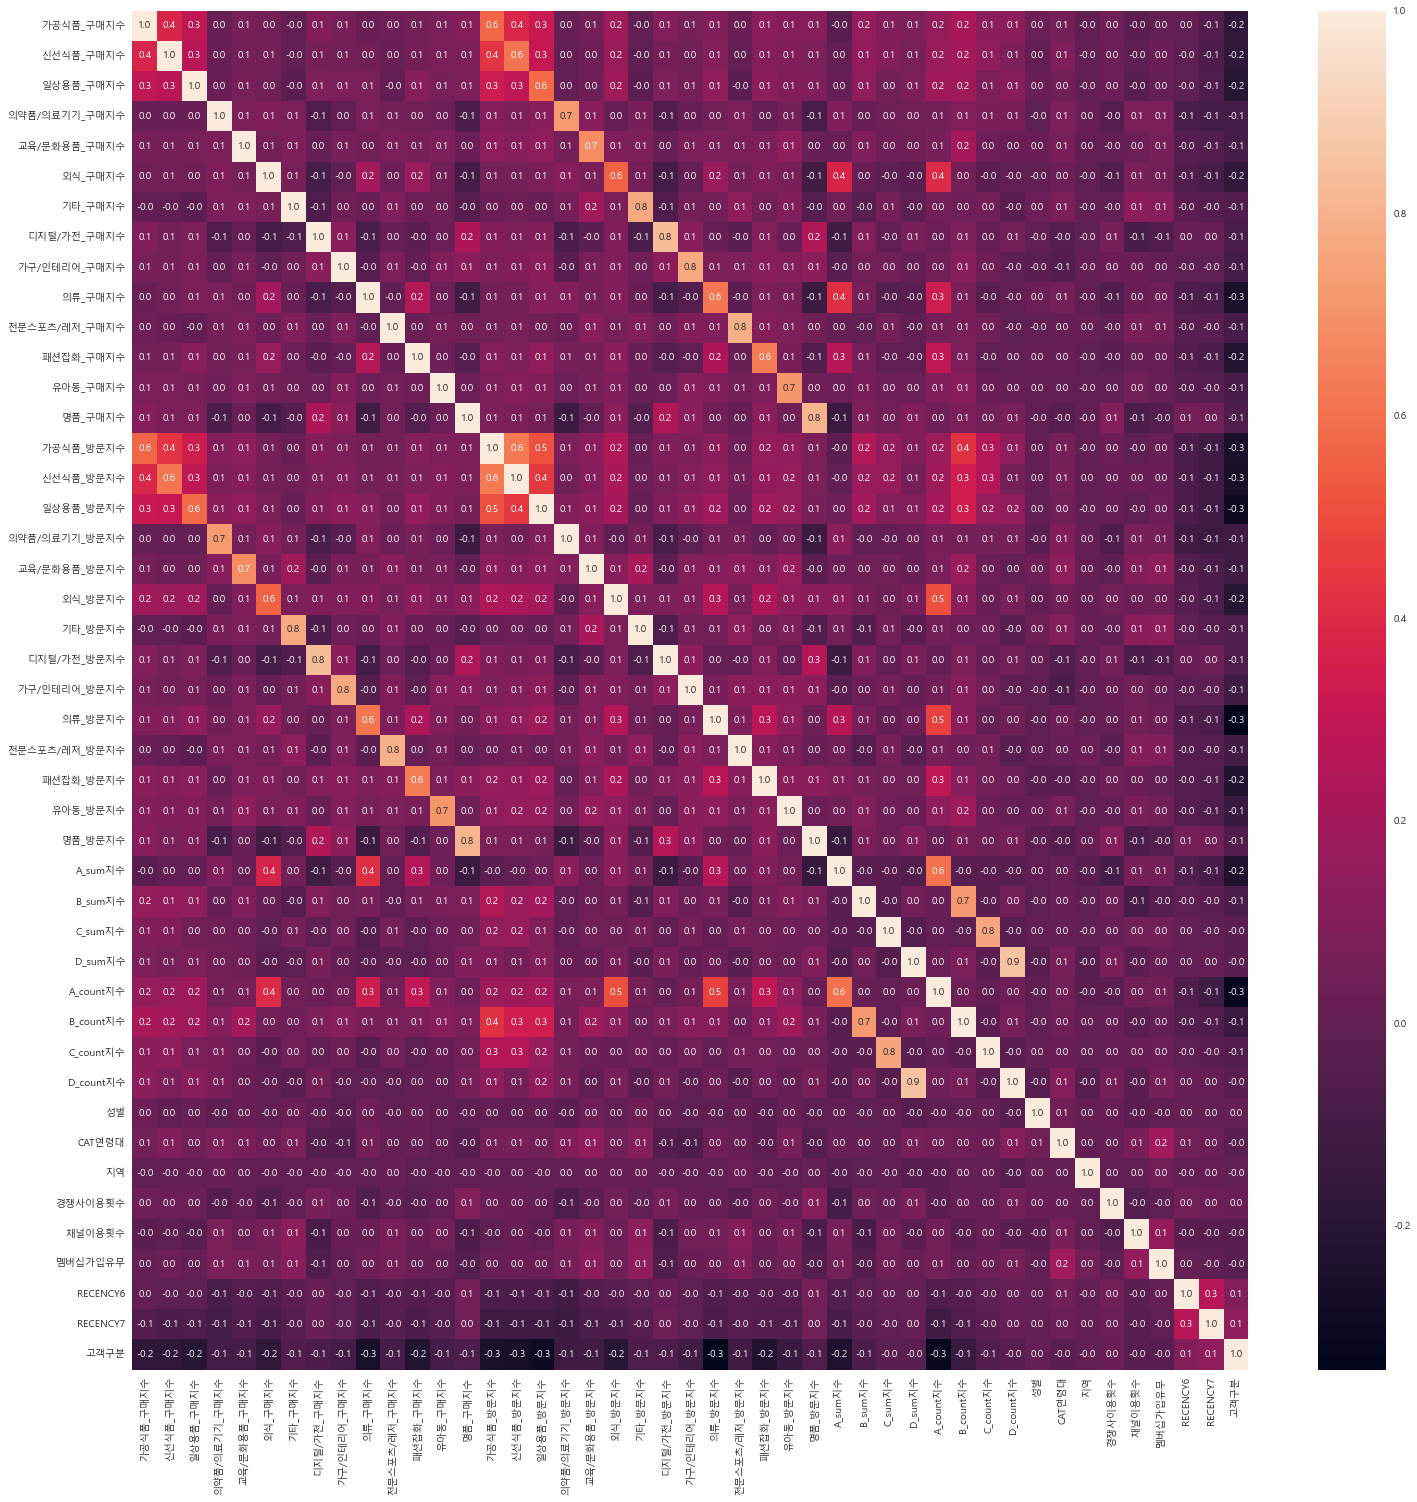

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_1.corr()
plt.figure(figsize = (25,25))
sns.heatmap(corr, annot = True, fmt = '.1f');

In [28]:
df_1 = df.drop('고객번호',axis=1)
df_1.고객구분=df_1.고객구분.astype('int64')

In [31]:
df_1.corr()['고객구분'].sort_values(ascending= True)

의류_방문지수         -0.342479
A_count지수       -0.319131
일상용품_방문지수       -0.299102
신선식품_방문지수       -0.256869
의류_구매지수         -0.252707
가공식품_방문지수       -0.252432
패션잡화_방문지수       -0.231179
A_sum지수         -0.230029
패션잡화_구매지수       -0.217744
일상용품_구매지수       -0.203036
외식_방문지수         -0.201040
신선식품_구매지수       -0.171575
가공식품_구매지수       -0.170889
외식_구매지수         -0.165131
유아동_방문지수        -0.143113
B_count지수       -0.136106
의약품/의료기기_방문지수   -0.118674
교육/문화용품_방문지수    -0.116016
가구/인테리어_방문지수    -0.112760
전문스포츠/레저_방문지수   -0.104859
가구/인테리어_구매지수    -0.099051
의약품/의료기기_구매지수   -0.097121
전문스포츠/레저_구매지수   -0.093843
교육/문화용품_구매지수    -0.091677
유아동_구매지수        -0.086856
디지털/가전_구매지수     -0.073843
B_sum지수         -0.073655
디지털/가전_방문지수     -0.068668
명품_구매지수         -0.067322
기타_방문지수         -0.066134
명품_방문지수         -0.064324
기타_구매지수         -0.062286
C_count지수       -0.056886
D_count지수       -0.035417
채널이용횟수          -0.030910
멤버십가입유무         -0.028571
D_sum지수         -0.024030
C_sum지수         -0.023967
CAT연령대      

In [ ]:
# 속성끼리 상관도 높은 거 뽑아내서 차원 축소
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler # PCA는 속성에 영향을 받으니 각 속상값 스케일링 해줘야함 384P

scaler = StandardScaler()
df_cols_scaled = scaler.fit_transform(X_features['컬럼이름'])

pca = PCA(n_components = 2)
pca.fit(df_cols_scaled)
pca.explained_variance_ratio # 변동성 설명력 확인 

In [ ]:
from sklearn.preprocessing import StandardScaler

iris_scaled = StandardScaler().fit_transform(df_iris.iloc[:,:-1])

from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

iris_pca = pca.fit_transform(iris_scaled)
iris_pca.shape

print(pca.explained_variance_ratio_) # PCA 컴포넌트 별 설명력 

In [ ]:
# 원본 데이터 세트와 pca 변동한 데이터 세트 정확도 비교 (391p - 392p)

In [ ]:
# LDA는 fit 메서드 호출 시에 결정값 입력해줘야함 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

# 스케일링 역시 해줘야함 
iris_scaled = StandardScaler().fit_transform()

lda = LinearDiscriminantAnalysis(n_componets = 2)
lda.fit(iris_scaled, iris.target)
iris_lda = lda.transform(iris_scaled)


분류모델
1. 결정트리
2. 로지스틱 회귀
3. 랜덤포레스트
4. XGBooster
5. LightGBM

In [6]:
# 고객속성변수 데이터프레임 불러올 공간
# 성별, 연령대 (5개군), 거주지역, 경쟁사이용횟수, 채널이용횟수, 멤버십 가입 유무, 가장 최근에 방문한 날짜로부터 얼마나 지났는지
import pandas as pd
df0 = pd.read_csv('./dataset/고객속성변수.csv', encoding = 'CP949')

# train
df1 = pd.read_csv('./dataset/카테고리_구매지수(train).csv', encoding = 'CP949')
df2 = pd.read_csv('./dataset/카테고리_방문지수(train).csv', encoding = 'CP949')
df2 = pd.merge(df1, df2, on = '고객번호')

# test
df3 = pd.read_csv('./dataset/카테고리_구매지수(test).csv', encoding = 'CP949')
df4 = pd.read_csv('./dataset/카테고리_방문지수(test).csv', encoding = 'CP949')
df5 = pd.read_csv('./dataset/제휴사_구매지수(test).csv.csv',encoding = 'CP949')
df6 = pd.read_csv('./dataset/제휴사_방문지수(test).csv.csv',encoding = 'CP949')
df4 = pd.merge(df3, df4, on = '고객번호')

train = pd.merge(df0, df2, on = '고객번호')
test = pd.merge(df0, df4, on = '고객번호')

df.info()
df = df.set_index('고객번호')
X_train = df.drop(['고객구분', 'RECENCY7'], axis = 1)
y_train = train['고객구분']

X_test = df.drop(['고객구분','RECENCY6'], axis = 1)
y_test = test['고객구분']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18866 entries, 0 to 18865
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   고객번호           18866 non-null  int64  
 1   성별             18866 non-null  object 
 2   CAT연령대         18866 non-null  object 
 3   지역             18866 non-null  object 
 4   경쟁사이용횟수        18866 non-null  int64  
 5   채널이용횟수         18866 non-null  int64  
 6   멤버십가입개수        18866 non-null  int64  
 7   RECENCY6       18866 non-null  int64  
 8   RECENCY7       18866 non-null  int64  
 9   고객구분           18866 non-null  object 
 10  가공식품_방문횟수      18866 non-null  float64
 11  신선식품_방문횟수      18866 non-null  float64
 12  일상용품_방문횟수      18866 non-null  float64
 13  의약품/의료기기_방문횟수  18866 non-null  float64
 14  교육/문화용품_방문횟수   18866 non-null  float64
 15  외식_방문횟수        18866 non-null  float64
 16  기타_방문횟수        18866 non-null  float64
 17  디지털/가전_방문횟수    18866 non-null  float64
 18  가구/인테리

In [9]:
import pandas as pd
df0 = pd.read_csv('./dataset/고객속성변수.csv', encoding = 'CP949')
df3 = pd.read_csv('./dataset/카테고리_구매지수(test).csv', encoding = 'CP949')
df4 = pd.read_csv('./dataset/카테고리_방문지수(test).csv', encoding = 'CP949')
df5 = pd.read_csv('./dataset/제휴사_구매지수(test).csv',encoding = 'CP949')
df6 = pd.read_csv('./dataset/제휴사_방문지수(test).csv',encoding = 'CP949')
df7 = pd.merge(df3, df4, on = '고객번호')
df7 = pd.merge(df7, df5, on = '고객번호')
df7 = pd.merge(df7, df6, on = '고객번호')
df = pd.merge(df7, df0, on = '고객번호')
df.head()

,고객번호,가공식품_구매지수,신선식품_구매지수,일상용품_구매지수,의약품/의료기기_구매지수,교육/문화용품_구매지수,외식_구매지수,기타_구매지수,디지털/가전_구매지수,가구/인테리어_구매지수,...,D_count지수,성별,CAT연령대,지역,경쟁사이용횟수,채널이용횟수,멤버십가입개수,RECENCY6,RECENCY7,고객구분
0,1,0.4,0.4,-3.8,2.4,0.0,0.4,0.0,10.2,-0.6,...,0.0,M,노년층,서울,15,0,0,3,8,감소
1,2,0.4,0.0,0.8,2.8,0.0,0.4,0.0,7.6,5.2,...,3.8,M,노년층,경기,8,0,0,6,1,증가
2,3,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,M,노년층,서울,0,0,0,1,8,증가
3,4,0.0,0.0,0.4,4.4,0.0,1.4,0.0,0.0,8.8,...,0.0,F,노년층,서울,3,0,0,0,0,증가
4,6,0.0,1.4,0.4,0.0,4.0,0.8,0.0,0.0,10.2,...,0.0,F,노년층,강원,0,0,0,0,0,증가


In [10]:
# 레이블 인코딩 : 문자를 숫자로 바꿔줌
from sklearn.preprocessing import LabelEncoder 

features = ['성별', 'CAT연령대','지역']
for feature in features:
    le = LabelEncoder()
    le.fit(df[feature])
    df[feature] = le.transform(df[feature])
    
df.rename(columns = {'멤버십가입개수':'멤버십가입유무'},inplace=True)
df
# 성별 1이 남자, 고객구분 감소 0 증가 1 

,고객번호,가공식품_구매지수,신선식품_구매지수,일상용품_구매지수,의약품/의료기기_구매지수,교육/문화용품_구매지수,외식_구매지수,기타_구매지수,디지털/가전_구매지수,가구/인테리어_구매지수,...,D_count지수,성별,CAT연령대,지역,경쟁사이용횟수,채널이용횟수,멤버십가입유무,RECENCY6,RECENCY7,고객구분
0,1,0.4,0.4,-3.8,2.4,0.0,0.4,0.0,10.2,-0.6,...,0.0,1,0,8,15,0,0,3,8,감소
1,2,0.4,0.0,0.8,2.8,0.0,0.4,0.0,7.6,5.2,...,3.8,1,0,1,8,0,0,6,1,증가
2,3,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,1,0,8,0,0,0,1,8,증가
3,4,0.0,0.0,0.4,4.4,0.0,1.4,0.0,0.0,8.8,...,0.0,0,0,8,3,0,0,0,0,증가
4,6,0.0,1.4,0.4,0.0,4.0,0.8,0.0,0.0,10.2,...,0.0,0,0,0,0,0,0,0,0,증가
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18861,19333,0.0,-3.0,-2.0,0.0,-3.6,0.4,0.0,0.0,0.0,...,4.2,0,3,8,0,5,1,0,2,감소
18862,19334,-0.2,-0.2,-0.4,3.2,5.2,0.0,0.0,0.0,2.0,...,0.0,1,2,15,30,0,1,7,31,감소
18863,19335,1.0,0.0,1.0,2.4,2.0,0.8,0.0,0.0,0.2,...,0.0,0,2,13,0,0,1,1,0,증가
18864,19336,9.6,7.0,7.8,0.0,0.0,1.4,0.0,0.0,0.0,...,1.6,0,2,8,0,0,0,5,5,증가


In [11]:
from sklearn.preprocessing import MinMaxScaler

li = ['경쟁사이용횟수','RECENCY6','RECENCY7']
for i in li:
    scaler = MinMaxScaler()
    df[i] = scaler.fit_transform(df[[i]])
df.head()

,고객번호,가공식품_구매지수,신선식품_구매지수,일상용품_구매지수,의약품/의료기기_구매지수,교육/문화용품_구매지수,외식_구매지수,기타_구매지수,디지털/가전_구매지수,가구/인테리어_구매지수,...,D_count지수,성별,CAT연령대,지역,경쟁사이용횟수,채널이용횟수,멤버십가입유무,RECENCY6,RECENCY7,고객구분
0,1,0.4,0.4,-3.8,2.4,0.0,0.4,0.0,10.2,-0.6,...,0.0,1,0,8,0.375,0,0,0.033333,0.088889,감소
1,2,0.4,0.0,0.8,2.8,0.0,0.4,0.0,7.6,5.2,...,3.8,1,0,1,0.200,0,0,0.066667,0.011111,증가
2,3,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,1,0,8,0.000,0,0,0.011111,0.088889,증가
3,4,0.0,0.0,0.4,4.4,0.0,1.4,0.0,0.0,8.8,...,0.0,0,0,8,0.075,0,0,0.000000,0.000000,증가
4,6,0.0,1.4,0.4,0.0,4.0,0.8,0.0,0.0,10.2,...,0.0,0,0,0,0.000,0,0,0.000000,0.000000,증가


In [19]:
df.loc[df['고객구분'] == '감소', '고객구분'] = 1
df.loc[df['고객구분'] == '증가', '고객구분'] = 0
df.head()

,고객번호,가공식품_구매지수,신선식품_구매지수,일상용품_구매지수,의약품/의료기기_구매지수,교육/문화용품_구매지수,외식_구매지수,기타_구매지수,디지털/가전_구매지수,가구/인테리어_구매지수,...,D_count지수,성별,CAT연령대,지역,경쟁사이용횟수,채널이용횟수,멤버십가입유무,RECENCY6,RECENCY7,고객구분
0,1,0.4,0.4,-3.8,2.4,0.0,0.4,0.0,10.2,-0.6,...,0.0,1,0,8,0.375,0,0,0.033333,0.088889,1
1,2,0.4,0.0,0.8,2.8,0.0,0.4,0.0,7.6,5.2,...,3.8,1,0,1,0.200,0,0,0.066667,0.011111,0
2,3,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,1,0,8,0.000,0,0,0.011111,0.088889,0
3,4,0.0,0.0,0.4,4.4,0.0,1.4,0.0,0.0,8.8,...,0.0,0,0,8,0.075,0,0,0.000000,0.000000,0
4,6,0.0,1.4,0.4,0.0,4.0,0.8,0.0,0.0,10.2,...,0.0,0,0,0,0.000,0,0,0.000000,0.000000,0


In [32]:
X = df_1.drop(['고객구분','RECENCY6'],axis=1)
y = df_1['고객구분']

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

dt_clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 3, random_state = 156)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11, stratify = y)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)

In [36]:
get_clf_eval(y_test,pred)

오차 행렬
[[1829  346]
 [ 696  903]]
정확도 :0.7239, 정밀도:0.7230, 재현율: 0.5647, F1 스코어: 0.6341


모델평가

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def get_clf_eval (y_test, pred) : #평가할 때 실제값과 예측값 집어넣음
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test,pred)
    print('오차 행렬')
    print(confusion)
    print('정확도 :{0:.4f}, 정밀도:{1:.4f}, 재현율: {2:.4f}, F1 스코어: {3:.4f}'.format(accuracy, precision, recall, f1))

군집화모델
- 소개할 군집화 알고리즘
1.    Affinity Propagation
2.    Agglomerative Clustering
3.    BIRCH
4.    DBSCAN
5.    K-Means
6.    Mini-Batch K-Means
7.    Mean Shift
8.  OPTICS
9.  Spectral Clustering
10.  Gaussian Mixture Model

In [ ]:
# 왜곡 정도가 매우 높은 데이터 세트에 k-평균 군집을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행됨
# 평균,표준편차 재조정
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X = cust_df[['Recency', 'Frequency', 'Monetary']].values
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters = 3, random_state = 0)
labels = kmeans.fit_predict(X_scaled)
cust_df['cluster_label'] = labels
print(silhouette_score(X_scaled, labels))